In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


# Data Ingest

## Loading the train dataset

In [2]:
TRAIN_DATASET_FILE_LOCATION = '/kaggle/input/emotions-dataset-for-nlp/train.txt'

train_df = pd.read_csv(TRAIN_DATASET_FILE_LOCATION, sep=';', names=['text','emotion'])

In [3]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
len(train_df)

16000

In [5]:
train_df_tally = train_df['emotion'].value_counts()
train_df_tally

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [6]:
train_df_tally/sum(train_df_tally)

joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: emotion, dtype: float64

📔 We have an imbalanced dataset with the top 2 emotions comprising `~30%` of the dataset.

## Loading the validation dataset

In [7]:
VALIDATION_DATASET_FILE_LOCATION = '/kaggle/input/emotions-dataset-for-nlp/val.txt'

val_df = pd.read_csv(VALIDATION_DATASET_FILE_LOCATION, sep=';', names=['text','emotion'])
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [8]:
val_df_tally = val_df['emotion'].value_counts()
val_df_tally/sum(val_df_tally)

joy         0.3520
sadness     0.2750
anger       0.1375
fear        0.1060
love        0.0890
surprise    0.0405
Name: emotion, dtype: float64

# Exploratory Data Analysis (EDA)

* What is the distribution of length of the text?

In [9]:
length_array = [len(sent.split()) for sent in train_df['text']]
text_length_df = pd.DataFrame(length_array, columns=["text_length"])
text_length_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
text_length,16000.0,19.166313,10.986905,2.0,11.0,17.0,25.0,66.0


<Axes: ylabel='Frequency'>

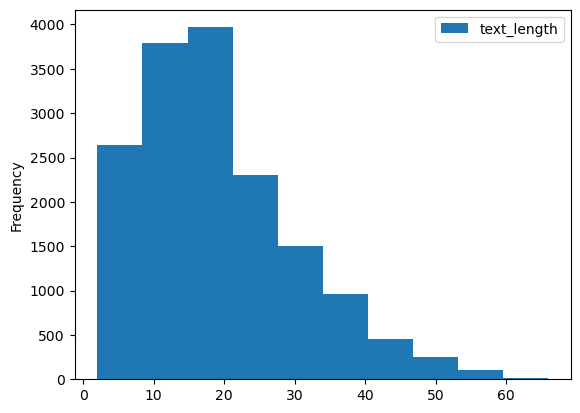

In [10]:
text_length_df.plot(kind='hist')

In [11]:
index_90th = int(len(length_array) * 0.90)
sorted(length_array)[index_90th]

35

📔 We'll use length `35` for out sentences as it covers `90%` of the lengths in our train dataset.